In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import arviz as az

from inference.cmb_ps import CMBPS
from inference.utils import unnormalize_phi, normalize_phi, log_prior_phi, sample_prior_phi, log_likelihood_eps_phi, get_phi_bounds
from inference.hmc import HMC

%load_ext line_profiler

In [2]:
device = 0

norm_phi_mode = 'compact'               # Normalization mode for phi among ['compact', 'inf', None]
phi_min, phi_max = get_phi_bounds()     # Bounds on phi (unnormalized)
phi_test = torch.tensor([70, 32.1e-3])  # True phi (unnormalized)

In [3]:
# Emulator of the CMB PS
ps_model = CMBPS(norm_input_phi=norm_phi_mode).to(device)

# Generate test observation
phi_test_norm = normalize_phi(phi_test, mode=norm_phi_mode).to(device)
print("Normalized test phi:", phi_test_norm)
ps_test = ps_model(phi_test_norm)
x_test = torch.fft.ifft2(torch.fft.fft2(torch.randn((256, 256), device=device))*torch.sqrt(ps_test)).real

Normalized test phi: tensor([0.5000, 0.5000])


In [4]:
#
# Prior, likelihood, and posterior functions
#

sample_prior = lambda n: sample_prior_phi(n, norm=norm_phi_mode, device=device)
log_likelihood = lambda phi, x: log_likelihood_eps_phi(phi, x, ps_model)
log_prior = lambda phi: log_prior_phi(phi, norm=norm_phi_mode)

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [5]:
def infer(x, nchains=20, nsamples=200, burnin=20, step_size=0.001, nleap=30, epsadapt=0, verbose=True):
    log_prob = lambda phi: log_posterior(phi, x)
    def log_prob_grad(phi):
        """ Compute the log posterior and its gradient."""
        phi.requires_grad_(True)
        log_prob = log_posterior(phi, x)
        grad_log_prob = torch.autograd.grad(log_prob, phi, grad_outputs=torch.ones_like(log_prob))[0]
        phi.requires_grad_(False)
        return log_prob.detach(), grad_log_prob
    hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)

    phi_0 = sample_prior(nchains)
    return hmc.sample(phi_0, nsamples=nsamples, burnin=burnin,step_size=step_size, nleap=nleap, epsadapt=epsadapt, verbose=verbose)

In [6]:
#
# Inference
#

burnin = 20
nsamples = 200
nchains = 20
stepsize = 0.005
nleap = 20
epsadapt = 50

samples = infer(x_test,
                nchains=nchains,
                nsamples=nsamples,
                burnin=burnin,
                step_size=stepsize,
                nleap=nleap,
                epsadapt=epsadapt,
                verbose=True)

Adapting step size using 50 iterations


100%|██████████| 51/51 [00:22<00:00,  2.31it/s]


Step size fixed to :  tensor([0.0111, 0.0104, 0.0121, 0.0109, 0.0110, 0.0103, 0.0113, 0.0121, 0.0120,
        0.0122, 0.0115, 0.0108, 0.0116, 0.0106, 0.0105, 0.0114, 0.0115, 0.0115,
        0.0108, 0.0115])


100%|██████████| 220/220 [01:23<00:00,  2.63it/s]


In [7]:
# Unnormalize samples
samples = unnormalize_phi(samples, mode=norm_phi_mode).cpu().numpy()

In [11]:
samples.shape

(20, 200, 2)

In [8]:
# Compute ESS and Rhat
az_infdata = az.convert_to_inference_data(samples)
ess = az.ess(az_infdata) # See https://python.arviz.org/en/stable/api/generated/arviz.ess.html
rhat = az.rhat(az_infdata) # See https://python.arviz.org/en/stable/api/generated/arviz.rhat.html
print("ESS: ", ess['x'].values)
print("Rhat: ", rhat['x'].values)

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


ESS:  [14408.23996531  8679.12752569]
Rhat:  [1.12225667 1.10791341]


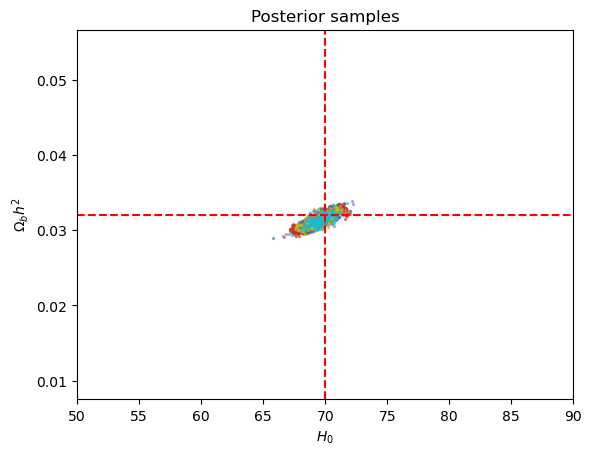

In [9]:
plt.figure()
for i in range(nchains):
    plt.scatter(samples[i, burnin:, 0], samples[i, burnin:, 1], s=2, alpha=0.5)
plt.axvline(phi_test[0].cpu(), color='red', linestyle='--')
plt.axhline(phi_test[1].cpu(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(phi_min[0], phi_max[0])
plt.ylim(phi_min[1], phi_max[1])
plt.title("Posterior samples")
plt.show()

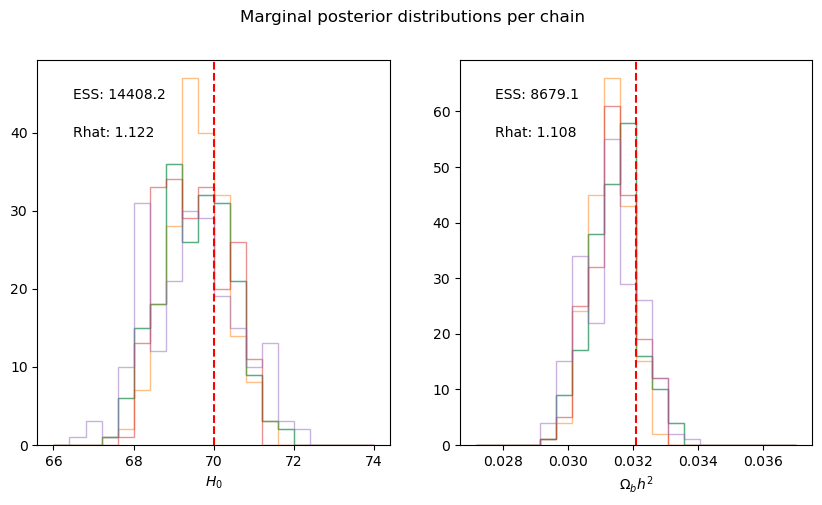

In [10]:
chains_id = np.random.randint(0, nchains, 5)

dphi = phi_max - phi_min
ranges_min = phi_test - 0.1*dphi
ranges_max = phi_test + 0.1*dphi

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in chains_id:
    axs[0].hist(samples[i, :, 0], alpha=0.5, bins=20, range=(ranges_min[0].item(), ranges_max[0].item()), histtype='step')
    axs[1].hist(samples[i, :, 1], alpha=0.5, bins=20, range=(ranges_min[1].item(), ranges_max[1].item()), histtype='step')
axs[0].axvline(phi_test[0].cpu(), color='red', linestyle='--')
axs[1].axvline(phi_test[1].cpu(), color='red', linestyle='--')
axs[0].set_xlabel(r"$H_0$")
axs[1].set_xlabel(r"$\Omega_b h^2$")
for i in range(2):
    xmin, xmax = axs[i].get_xlim()
    ymin, ymax = axs[i].get_ylim()
    axs[i].text(xmin + 0.1*(xmax - xmin), ymax - 0.1*(ymax - ymin), "ESS: {:.1f}".format(ess['x'].values[i]))
    axs[i].text(xmin + 0.1*(xmax - xmin), ymax - 0.2*(ymax - ymin), "Rhat: {:.3f}".format(rhat['x'].values[i]))
plt.suptitle("Marginal posterior distributions per chain")
plt.show()